# Flood Processor

The `FloodProcessor` is responsible for opening, visualizing and assessing the floods and waters created previously by the `FloodFinder` module. 

In [1]:
%load_ext autoreload
%autoreload 2

from dateutil.parser import parse
import logging 
import planetary_computer as pc
import pystac_client

import geopandas as gpd
import matplotlib.pyplot as plt

from flood_finder.urban_areas import UrbanAreas
from flood_finder.imagery import ImageFinder
from flood_finder.waterfinder import WaterFinder
from flood_finder.floodprocessor import FloodProcessor

## Select a Sample Area

In [2]:
uas = UrbanAreas('/data/RS_BR_Urban_Areas/')

In [3]:
# iterator = uas.iter_cities(0.5, (1.2,1))
# ua = next(iter(iterator))

ua = uas.get_urban_area("Rolante", area_factor=0.5, figsize=(1.2, 1))

<Axes: >

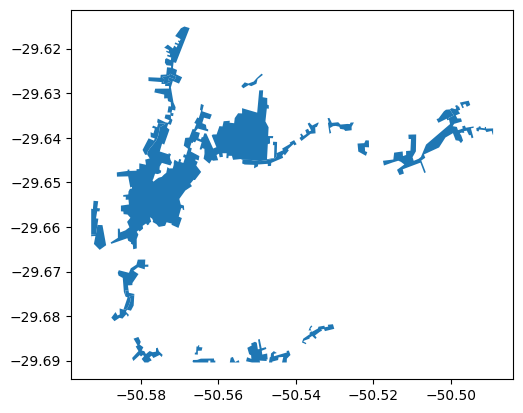

In [4]:
ua.df.plot()

In [5]:
ROOT = '/data/flood_finder'
ua.get_folder(ROOT)

PosixPath('/data/flood_finder/Rolante')

## Create a Processor

The processor needs the GeoDataFrame with the polygons to be considered. 
In this case, we are going to pass `ua.df`

In [6]:
pc.set_subscription_key('60c2795c5764470ca21438274583378d')

In [7]:
processor = FloodProcessor(
    aoi_df=ua.df,
    output_dir=ua.get_folder(ROOT),
    dem='/data/anadem_pitless.tif', 
    hand='/data/anadem_hand.tif',
    time_range='2016-01/2023',
    print_log=True,
    log_level=logging.DEBUG,

)


2023-12-08 11:20:15 | Rolante.FloodProcessor:INFO -> Creating processor for place: Rolante
2023-12-08 11:20:15 | Rolante.FloodProcessor:INFO -> Saving file /data/flood_finder/Rolante/gdf.geojson
2023-12-08 11:20:16 | Rolante.WaterFinder:INFO -> Starting WaterFinder instance for Rolante
2023-12-08 11:20:16 | Rolante.WaterFinder:INFO -> Retrieving water recurrence
2023-12-08 11:20:21 | Rolante.WaterFinder:INFO -> Retrieving dates list for the AOI
2023-12-08 11:20:25 | Rolante.FloodProcessor:INFO -> Get water_recurrence from WaterFinder
2023-12-08 11:20:25 | Rolante.FloodProcessor:INFO -> Loading DEM from /data/anadem_pitless.tif
2023-12-08 11:20:25 | Rolante.FloodProcessor:INFO -> Loading HAND from /data/anadem_hand.tif


In [11]:
processor

Flood Processor for place: Rolante
Variables: dict_keys(['aoi_df', 'recurrence', 'dem', 'hand'])
WaterFinder for place Rolante
Available dates: 343
Water detected dates: 50

In [12]:
processor.find_water(resume=True, model='../data/RF_Model_v2.joblib')

  0%|          | 0/343 [00:00<?, ?it/s]

2023-12-08 11:22:13 | Rolante.WaterFinder:INFO -> Seeking for flood in date: 2021-02-21
2023-12-08 11:22:37 | Rolante.WaterFinder:INFO -> Seeking for flood in date: 2021-02-14
2023-12-08 11:23:04 | Rolante.WaterFinder:INFO -> Seeking for flood in date: 2021-02-09
2023-12-08 11:23:41 | Rolante.WaterFinder:INFO -> Seeking for flood in date: 2021-02-02
2023-12-08 11:24:01 | Rolante.WaterFinder:INFO -> Seeking for flood in date: 2021-01-28
2023-12-08 11:24:46 | Rolante.WaterFinder:INFO -> Seeking for flood in date: 2021-01-21
2023-12-08 11:25:04 | Rolante.WaterFinder:INFO -> Seeking for flood in date: 2021-01-16
2023-12-08 11:25:52 | Rolante.WaterFinder:INFO -> Seeking for flood in date: 2021-01-09
2023-12-08 11:26:18 | Rolante.WaterFinder:INFO -> Seeking for flood in date: 2021-01-04
2023-12-08 11:27:04 | Rolante.WaterFinder:INFO -> Seeking for flood in date: 2020-12-28
2023-12-08 11:27:29 | Rolante.WaterFinder:INFO -> Seeking for flood in date: 2020-12-23
2023-12-08 11:28:10 | Rolante.Wa

In [35]:
self = processor

In [174]:
self.process_floods()

2023-12-07 22:56:37 | Montenegro.FloodProcessor:INFO -> Calculating flood area for each date


  0%|          | 0/170 [00:00<?, ?it/s]

2023-12-07 22:56:41 | Montenegro.FloodProcessor:INFO -> table.csv exported with water/flood series
2023-12-07 22:56:41 | Montenegro.FloodProcessor:INFO -> calculating the extrapolated flood


In [38]:
self['data_table'] = self['water_series'].rename('Water Extents').to_frame()

In [59]:
self['data_table']['Water Extents'].argmax()

141

In [60]:
self['data_table'].iloc[141]

Water Extents    5334
Name: 2017-06-11 00:00:00, dtype: int64

In [134]:
import skimage
from tqdm.notebook import tqdm

def find_flood(self: FloodProcessor, date, recurrence_threshold):
    water = self['waters'][date]
    flood_arr = (
        water.where(self["hand"].data < 10).data
        - (self["recurrence"] > recurrence_threshold).data
    ) == 1
    
    # clean the prediction
    # kernel = skimage.morphology.square(2)
    # flood_arr = skimage.morphology.opening(flood_arr, footprint=kernel)
    flood_arr = skimage.morphology.remove_small_objects(flood_arr, min_size=25)
    flooded = self["recurrence"].copy()
    flooded.data = flood_arr
    
    return flooded


def extrapolate_flood(self: FloodProcessor, recurrence_threshold):
    


In [170]:
import numpy as np

# date_max = self['data_table'].index.astype('str')[self['data_table']['Flood area'].argmax()]
# # date_max = '2017-06-11'
# max_flood = self.find_flood(date_max, recurrence_threshold=10)
try:
    (
        self.vars["flooded_regions"],
        self.vars["labels"],
        self.vars["dem_steps"],
    ) = self.extrapolate_flood()
    floods = np.stack(self["flooded_regions"])
    self.vars["extrapolated_flood"] = self["dem"].copy()
    self.vars["extrapolated_flood"].data = floods.any(axis=0).astype("int")
except Exception as e:  # pylint: disable=broad-except
    print(e)


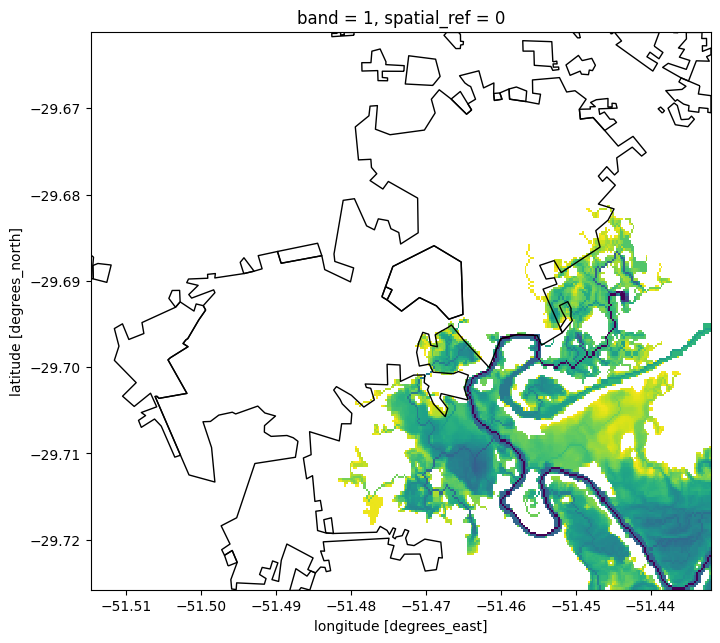

In [177]:
fig, ax = plt.subplots(figsize=(8,8))
self.plot_extrapolated_flood(ax=ax)

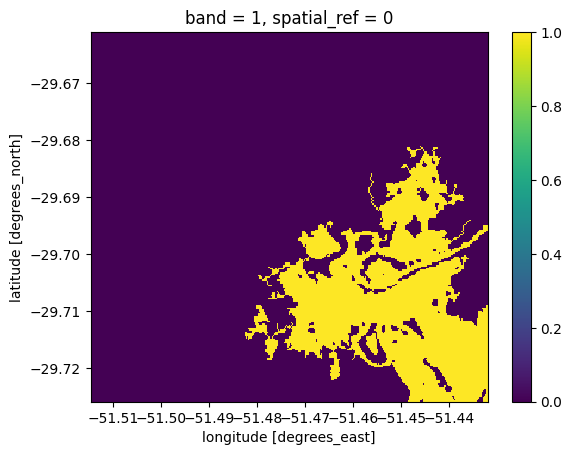

In [172]:
self['extrapolated_flood'].plot()

In [173]:
processor

Flood Processor for place: Montenegro
Variables: dict_keys(['aoi_df', 'recurrence', 'waters', 'dem', 'hand', 'water_series', 'data_table', 'flooded_regions', 'labels', 'dem_steps', 'extrapolated_flood'])

In [154]:
self['water_series'].index[self['water_series'].argmax()]

Timestamp('2017-06-11 00:00:00')

In [ ]:
processor.process_floods()

<Axes: >

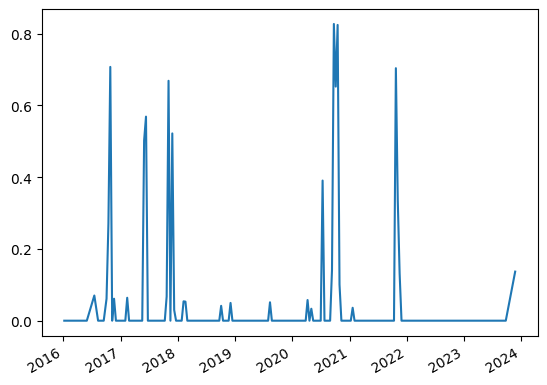

In [130]:
self['data_table']['Flood area'].plot()

In [112]:
int(flood.sum()) * .0009

0.5688

In [168]:
self['data_table']

Water Extents   area  Flood area
2016-02-23            152  234.0      0.0000
2016-01-30            182    NaN      0.0000
2016-01-06            116    NaN      0.0000
2016-03-30            123    NaN      0.0000
2016-03-18            127    NaN      0.0000
...                   ...    ...         ...
2016-08-09            186    NaN      0.0000
2016-07-16           3496    NaN      0.0702
2016-05-29            176    NaN      0.0000
2016-05-17            184    NaN      0.0000
2016-05-05            142    NaN      0.0000

[170 rows x 3 columns]

In [107]:
(30*30) / (1000 * 1000)

0.0009

In [111]:
1e-4

0.0001

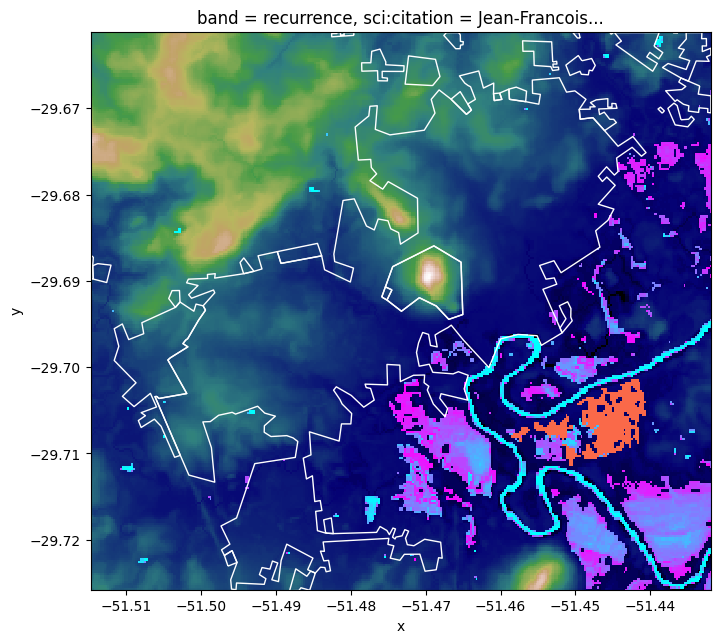

In [165]:
fig, ax = plt.subplots(figsize=(8,8))
self.plot_flood(ax=ax, date=date_max)

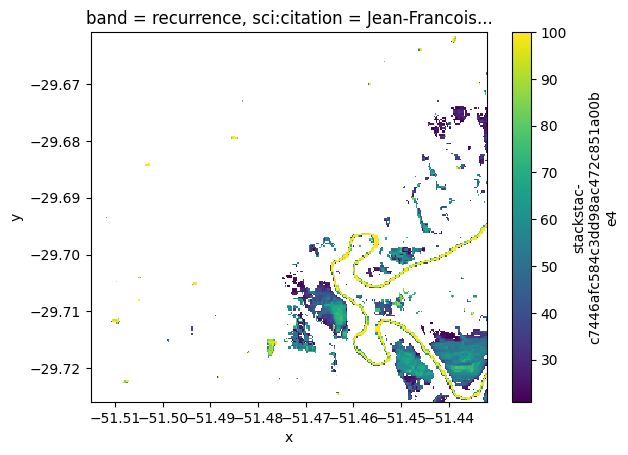

In [98]:
recurrent_water.plot()

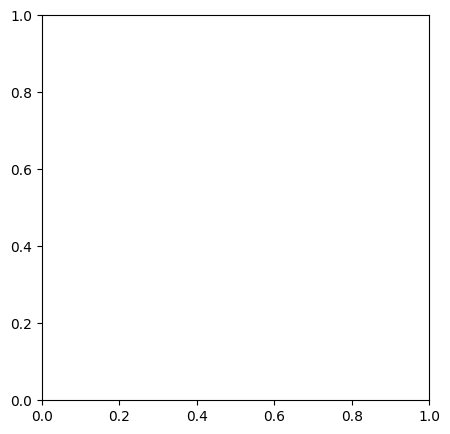

In [88]:

flood = find_flood(self, '2017-06-11', 10)

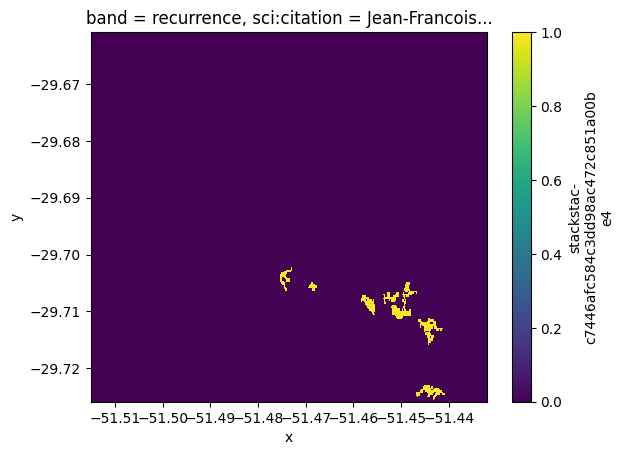

In [86]:
flood.plot()

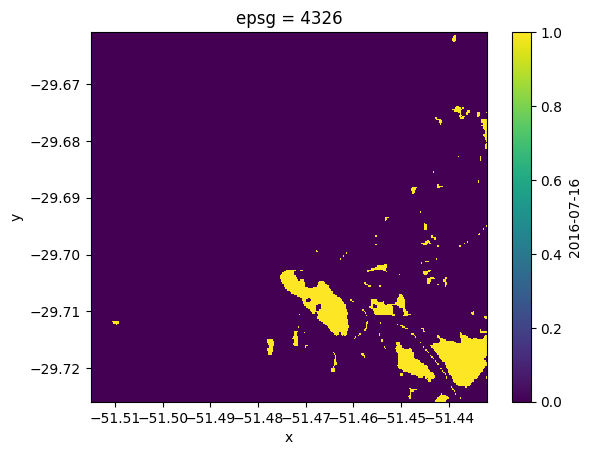

In [57]:
self['waters']['2016-07-16'].plot()

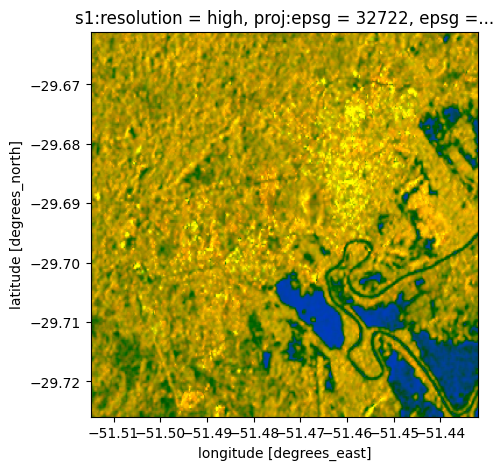

In [63]:
fig, ax = plt.subplots(figsize=(5,5))
self.finder.s1imagery.plot_date('2017-06-11', ax=ax)

In [ ]:

def plot_date(self, date):
    self.s1imagery.plot()    

<Axes: >

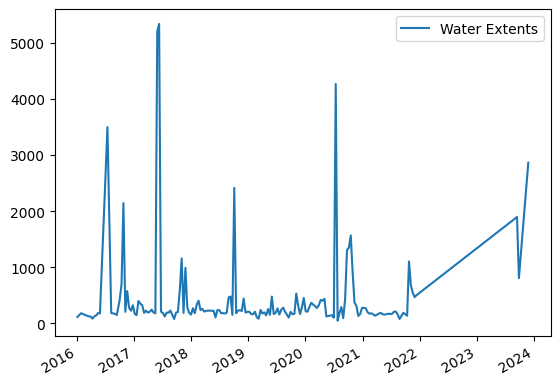

In [40]:
self['data_table'].plot()

In [22]:
processor

Flood Processor for place: Montenegro
Variables: dict_keys(['aoi_df', 'recurrence', 'waters', 'dem', 'hand'])

In [30]:
self = processor
water_series = self["waters"].to_array(dim='time').sum(dim=["x", "y"]).to_series()
water_series.index = [parse(date) for date in water_series.index]

In [31]:
water_series

2016-02-23    152
2016-01-30    182
2016-01-06    116
2016-03-30    123
2016-03-18    127
2016-04-23    126
2016-04-11     87
dtype: int64

<Axes: >

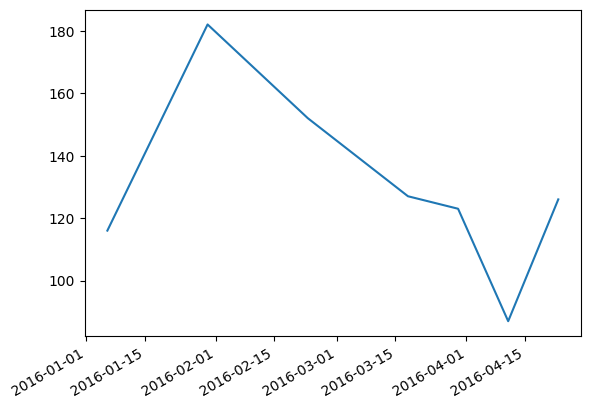

In [32]:
water_series.plot()

In [109]:
processor.find_water(
    model='../data/RF_Model_v2.joblib',
    time_range='2016',
    lee_size=7,
    resume=False
)

processor

  0%|          | 0/22 [00:00<?, ?it/s]

AttributeError: 'Dataset' object has no attribute 'to_series'

In [115]:
processor['waters']

<xarray.Dataset>
Dimensions:                                (x: 333, y: 260)
Coordinates: (12/44)
  * x                                      (x) float64 -51.51 -51.51 ... -51.43
  * y                                      (y) float64 -29.66 -29.66 ... -29.73
    sar:looks_range                        int64 5
    sar:looks_equivalent_number            float64 4.4
    proj:bbox                              object {257970.0, 6804940.0, 55270...
    title                                  <U41 'VV: vertical transmit, verti...
    ...                                     ...
    proj:transform                         object {0.0, 1.0, 10.0, 6804940.0,...
    sar:pixel_spacing_range                int64 10
    constellation                          <U10 'Sentinel-1'
    sar:frequency_band                     <U1 'C'
    s1:resolution                          <U4 'high'
    spatial_ref                            int64 0
Data variables: (12/22)
    2016-12-25                             (y, x) int64 -9223372036854775808 ...
    2016-12-13                             (y, x) int64 -9223372036854775808 ...
    2016-12-01                             (y, x) int64 -9223372036854775808 ...
    2016-11-19                             (y, x) int64 -9223372036854775808 ...
    2016-11-07                             (y, x) int64 -9223372036854775808 ...
    2016-10-26                             (y, x) int64 -9223372036854775808 ...
    ...                                     ...
    2016-04-11                             (y, x) int64 -9223372036854775808 ...
    2016-03-30                             (y, x) int64 -9223372036854775808 ...
    2016-03-18                             (y, x) int64 -9223372036854775808 ...
    2016-02-23                             (y, x) int64 -9223372036854775808 ...
    2016-01-30                             (y, x) int64 -9223372036854775808 ...
    2016-01-06                             (y, x) int64 -9223372036854775808 ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

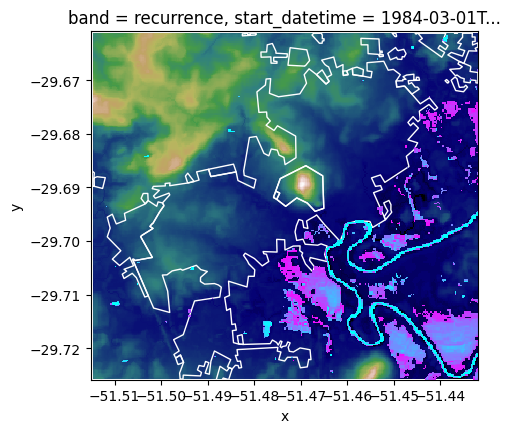

In [91]:
fig, ax = plt.subplots(figsize=(5,5))
processor.plot_recurrent_water(ax=ax)

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
processor['recurrence']

<xarray.DataArray 'stackstac-944f9b424a2112cc03719f5dd1c8eb95' (y: 260, x: 333)>
dask.array<getitem, shape=(260, 333), dtype=float64, chunksize=(260, 333), chunktype=numpy.ndarray>
Coordinates: (12/14)
    band            <U10 'recurrence'
  * x               (x) float64 -51.52 -51.51 -51.51 ... -51.43 -51.43 -51.43
  * y               (y) float64 -29.66 -29.66 -29.66 ... -29.73 -29.73 -29.73
    start_datetime  <U20 '1984-03-01T00:00:00Z'
    proj:bbox       object {-30.0, -60.0, -20.0, -50.0}
    proj:shape      object {40000}
    ...              ...
    sci:doi         <U19 '10.1038/nature20584'
    sci:citation    <U169 'Jean-Francois Pekel, Andrew Cottam, Noel Gorelick,...
    proj:epsg       int64 4326
    description     <U146 'Provides information concerning the inter-annual b...
    title           <U16 'Water Recurrence'
    epsg            int64 4326

In [66]:

processor.parent_logger.handlers

[<FileHandler /data/flood_finder/Teste/log.txt (NOTSET)>]

In [55]:
processor['teste'] = 'a'

In [68]:
ua.df.total_bounds

array([-51.51477046, -29.7259058 , -51.43193674, -29.66121003])

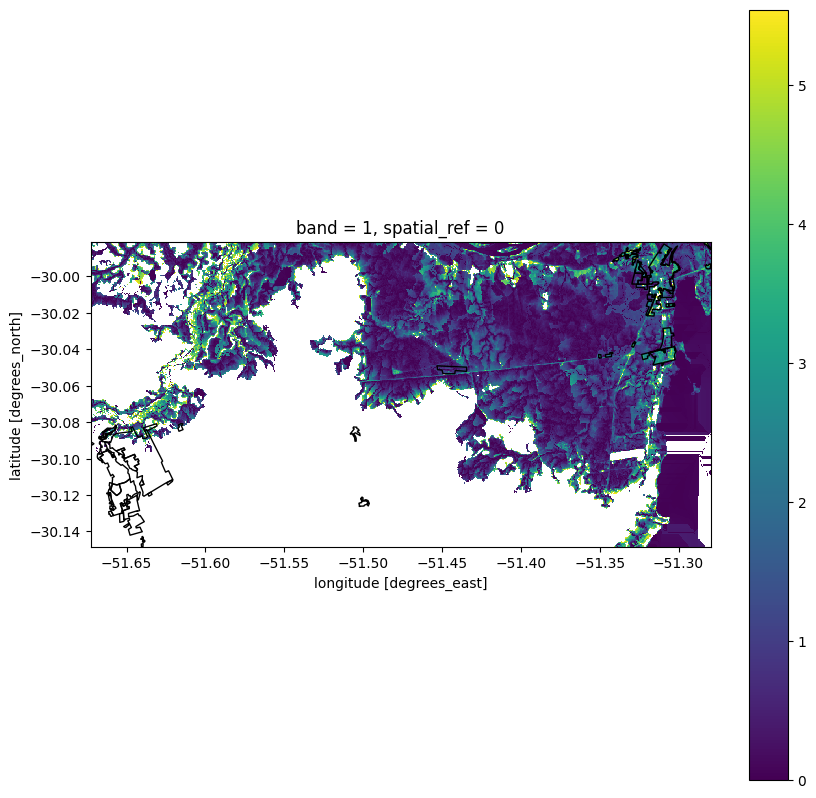

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
# water.where(water>0).plot(ax=ax, add_colorbar=False)
# flood.where(flood>0).plot(ax=ax, cmap='Reds', add_colorbar=False)


processor['hand'].where(processor['extrapolated_flood']>0).plot(vmin=0, add_colorbar=True)
# processor['dem'].plot(add_colorbar=True, vmin=0)
processor.plot_var('urban_area', ax=ax, facecolor='none')


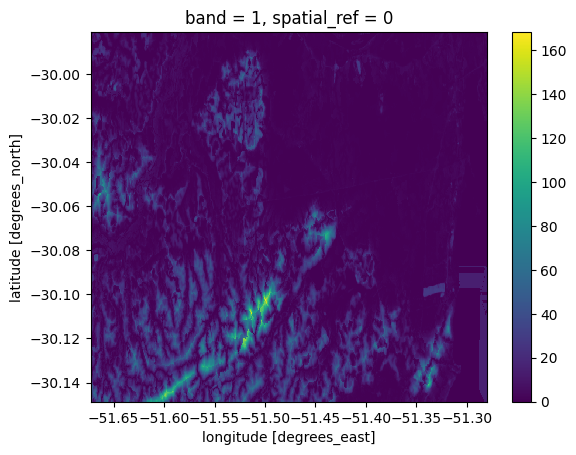

In [40]:
fig, ax = plt.subplots()

processor.plot_var('hand', ax=ax)

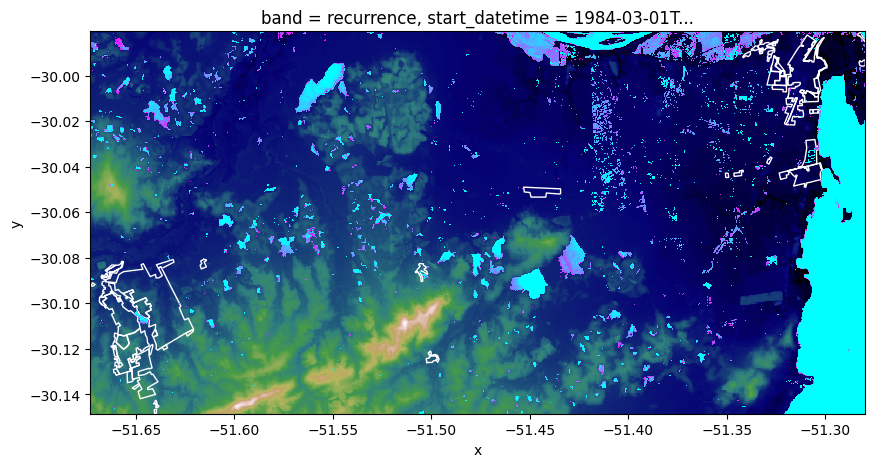

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
processor.plot_vars(ax=ax,dem='dem')
# water.where(water>0).plot(ax=ax, add_colorbar=False)
# flood.where(flood>0).plot(ax=ax, cmap='Reds', add_colorbar=False)


<Axes: >

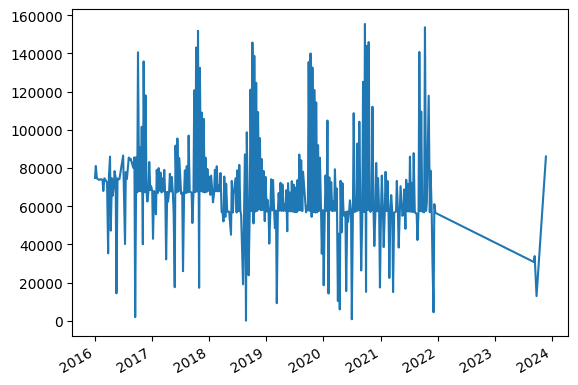

In [43]:
waters = processor['waters']
water_series = processor['waters'].sum(dim=['x', 'y']).to_series()
water_series.index = [parse(date) for date in waters.long_name]
water_series.plot()

<Axes: >

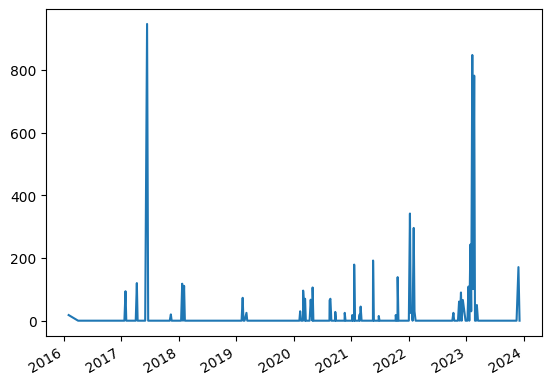

In [179]:
floods = processor['floods']
floods_series = processor['floods'].sum(dim=['x', 'y']).to_series()
floods_series.index = [parse(date) for date in floods.long_name]
floods_series.plot()

In [180]:
floods_series.sort_values(ascending=False)[:10]

2017-06-14    947
2023-02-08    848
2023-02-20    782
2017-06-09    552
2022-01-08    342
2022-02-01    296
2023-01-27    243
2021-05-19    192
2021-01-19    179
2023-11-28    171
dtype: int64

45


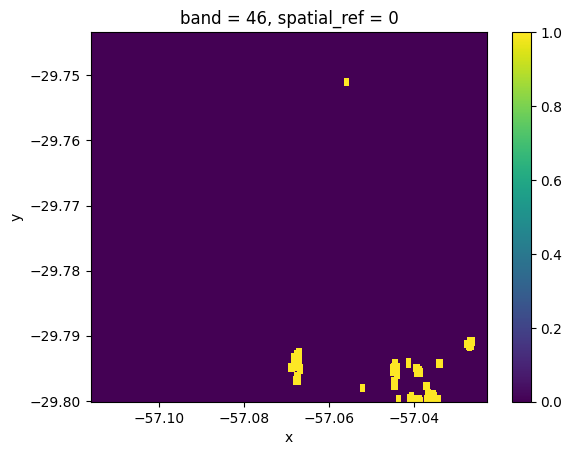

In [189]:
idx = floods_series.index.get_loc('2023-02-08')
# del floods.attrs['long_name']
print(idx)
floods[idx].plot()

In [193]:
import planetary_computer as pc
pc.set_subscription_key('60c2795c5764470ca21438274583378d')
s1imagery = processor.image_finder.get_s1_images(processor['aoi'], time_range='2016/2023')

/usr/local/lib/python3.10/dist-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/usr/local/lib/python3.10/dist-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


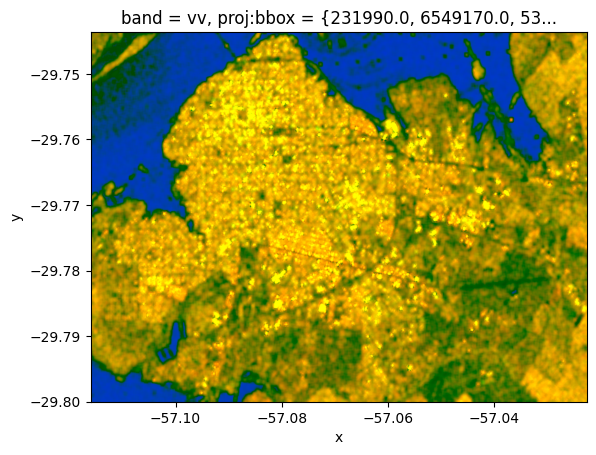

In [197]:
s1imagery.plot_date('2017-06-14')

/usr/local/lib/python3.10/dist-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/usr/local/lib/python3.10/dist-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


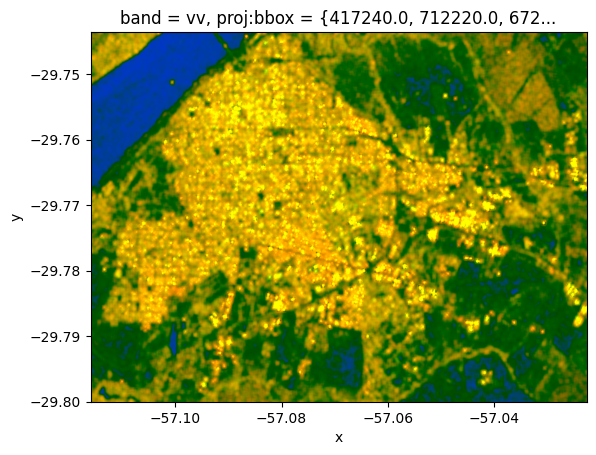

In [198]:
s1imagery.plot_date('2023-02-08')

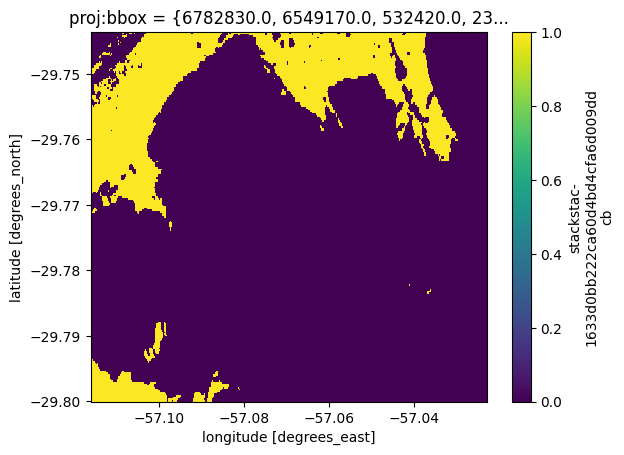

In [221]:
s1img = s1imagery['2017-06-14'].rio.reproject(dst_crs='epsg:4326', shape=floods.shape[1:3])
import joblib
classifier = joblib.load('../data/RF_Model_v2.joblib')
predicted_water = WaterFinder.predict_water(classifier, s1img, thresh=0.5)
predicted_water.plot()

In [ ]:
s1img.shape

(2, 621, 898)

In [173]:
water_series.sort_values(ascending=False)[:5]

2017-06-14    14926
2017-06-02    12040
2023-10-30    11969
2023-11-11    10357
2017-06-21    10043
dtype: int64

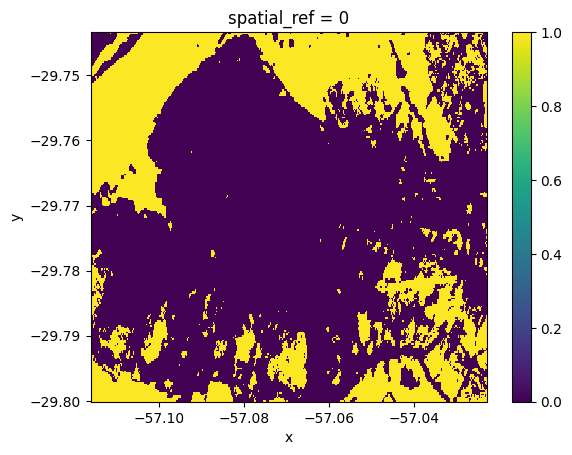

In [168]:
waters.any(dim='band').plot()

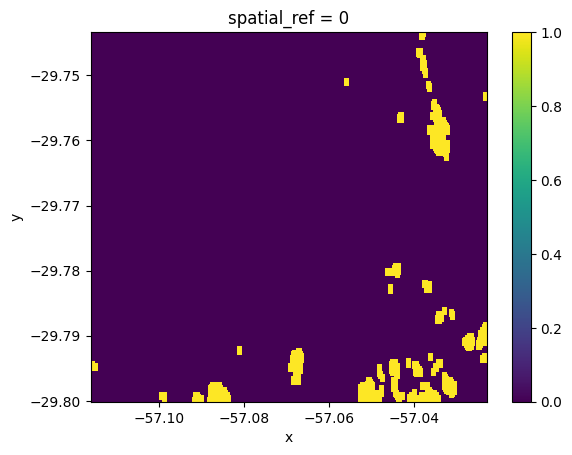

In [169]:
floods = processor['floods']
floods.any(dim='band').plot()

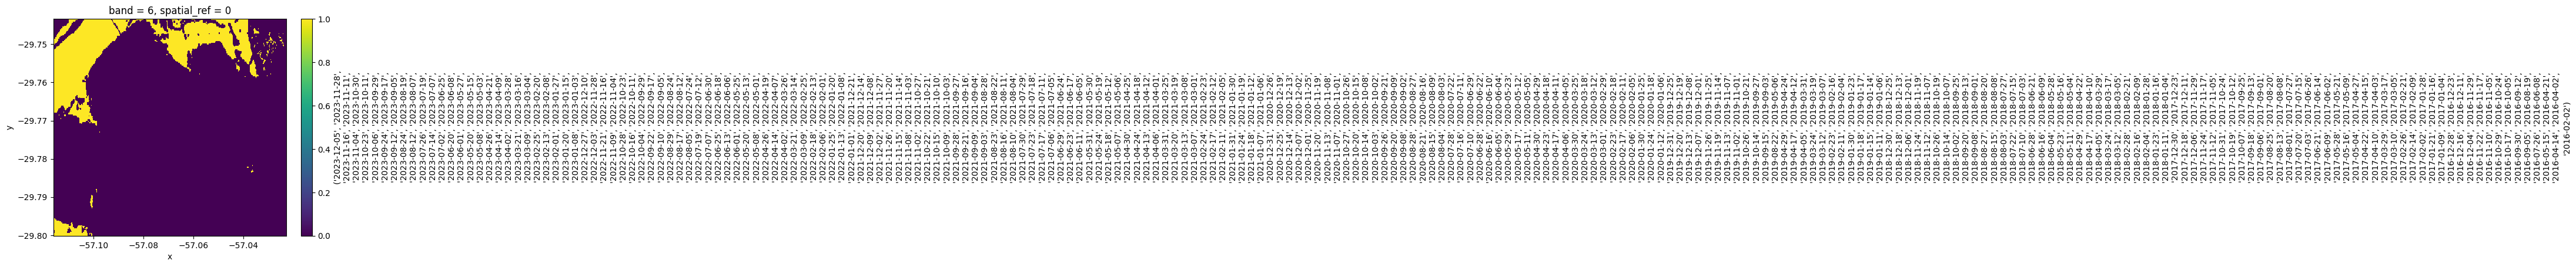

In [178]:
waters[5].plot()

In [88]:
water_series.iloc[water_series.argmax()]

4459

In [176]:
water_series.index.get_loc('2023-10-30')

5

In [159]:
water_series.argmax()

417

In [158]:
water_series.index[water_series.argmax()]

Timestamp('2017-06-14 00:00:00')

In [99]:
import planetary_computer as pc
pc.set_subscription_key('60c2795c5764470ca21438274583378d')
s1imagery = processor.image_finder.get_s1_images(self['aoi'], time_range='2016/2023')

In [104]:
s1imagery.dates

array(['2021-12-16', '2021-12-04', '2021-11-22', '2021-11-10',
       '2021-10-29', '2021-10-17', '2021-10-05', '2021-09-23',
       '2021-09-11', '2021-08-30', '2021-08-18', '2021-08-06',
       '2021-07-25', '2021-07-13', '2021-07-01', '2021-06-19',
       '2021-06-07', '2021-05-26', '2021-05-14', '2021-05-02',
       '2021-04-20', '2021-04-08', '2021-03-27', '2021-03-15',
       '2021-03-03', '2021-02-19', '2021-02-07', '2021-01-26',
       '2021-01-14', '2021-01-02', '2020-12-21', '2020-12-09',
       '2020-11-27', '2020-11-15', '2020-11-03', '2020-10-22',
       '2020-10-10', '2020-09-28', '2020-09-16', '2020-09-04',
       '2020-08-23', '2020-08-11', '2020-07-30', '2020-07-18',
       '2020-07-06', '2020-06-24', '2020-06-12', '2020-05-31',
       '2020-05-19', '2020-05-07', '2020-04-25', '2020-04-13',
       '2020-04-01', '2020-03-20', '2020-03-08', '2020-02-25',
       '2020-02-13', '2020-02-01', '2020-01-20', '2020-01-08',
       '2019-12-27', '2019-12-15', '2019-12-03', '2019-

/usr/local/lib/python3.10/dist-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/usr/local/lib/python3.10/dist-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


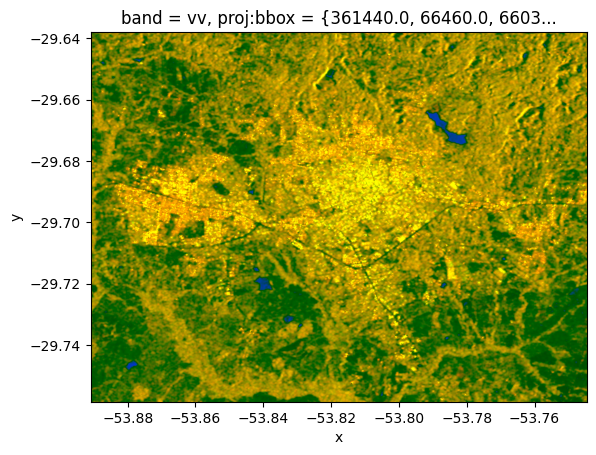

In [105]:
s1imagery.plot_date('2020-04-13')

/usr/local/lib/python3.10/dist-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/usr/local/lib/python3.10/dist-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


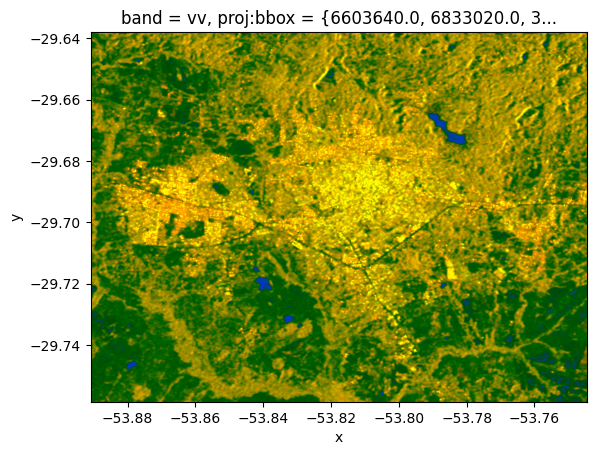

In [ ]:
s1imagery.plot_date('2020-04-25')

In [106]:
water = processor['waters'][50]